In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import IsolationForest

# Regression
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from keras.layers import Dense, Input

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.neighbors import KNeighborsClassifier

# CLustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.stats import mode
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering as HClust
from ISLP.cluster import compute_linkage 
from scipy.cluster.hierarchy import dendrogram

## First Look at Dataset

In [3]:
virus_df = pd.read_excel('2022QUB_virus_data.xlsx', sheet_name='Data')

In [4]:
virus_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3801 entries, 0 to 3800
Columns: 516 entries, SID to I512
dtypes: float64(512), int64(1), object(3)
memory usage: 15.0+ MB


In [5]:
virus_df.head()

,SID,Type,Matrix,Load,I001,I002,I003,I004,I005,I006,...,I503,I504,I505,I506,I507,I508,I509,I510,I511,I512
0,S1,X,dmem,1,97.78,97.73,97.68,97.70,97.73,97.73,...,83.38,84.49,84.94,85.47,86.16,86.79,87.12,87.20,87.58,88.20
1,S1,X,dmem,1,97.75,97.70,97.70,97.71,97.71,97.72,...,83.65,84.77,85.34,85.27,85.69,85.52,85.27,85.28,85.41,85.65
2,S1,X,dmem,1,97.76,97.72,97.70,97.74,97.71,97.71,...,84.46,85.38,86.03,86.38,86.77,87.10,87.14,86.89,87.14,87.79
3,S1,X,dmem,1,97.72,97.71,97.71,97.73,97.70,97.71,...,83.96,84.89,85.43,85.30,85.80,86.18,86.39,86.63,87.21,87.76
4,S1,X,dmem,1,97.74,97.66,97.65,97.68,97.67,97.65,...,83.65,84.02,84.33,84.53,85.14,85.40,85.41,85.42,85.88,85.87


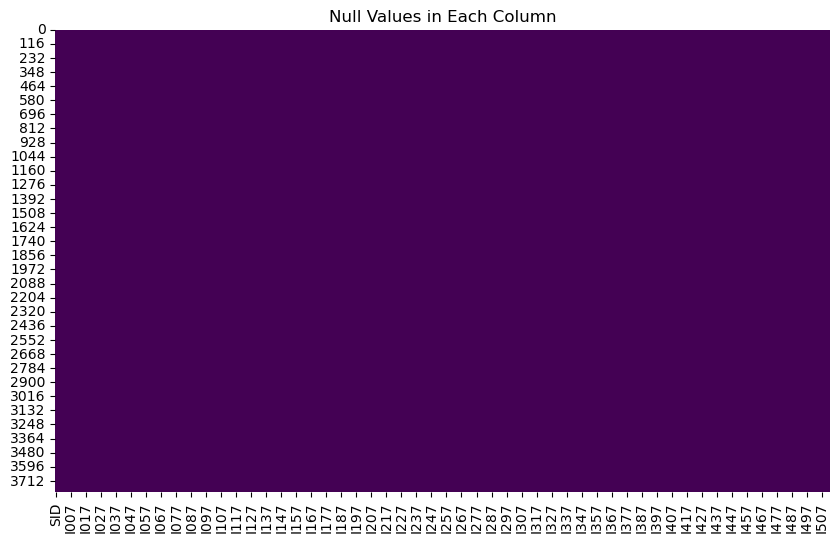

In [6]:
# Function for graphing null values in data frame
def graph_nulls (data):
    weather_df = data
    plt.figure(figsize=(10, 6))
    sns.heatmap(weather_df.isnull(), cmap='viridis', cbar=False)
    plt.title('Null Values in Each Column')
    plt.show

graph_nulls(virus_df)

# 1. Regression

In [8]:
# Subset data set by matrix, being careful of proceding whitespace !
dmem_virus_df = virus_df.loc[virus_df['Matrix'] == ' dmem']
pbs_virus_df = virus_df[virus_df['Matrix'] == ' pbs']

print(f'N | dmem: {dmem_virus_df.shape[0]}, pbs: {pbs_virus_df.shape[0]}')


N | dmem: 1831, pbs: 1970


<Axes: >

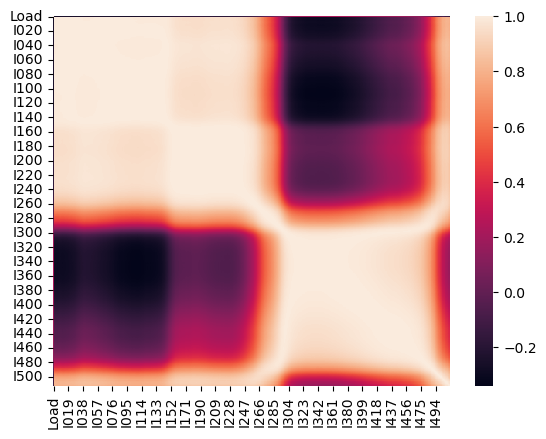

In [9]:
sns.heatmap(pbs_virus_df.corr(numeric_only=True))

<Axes: >

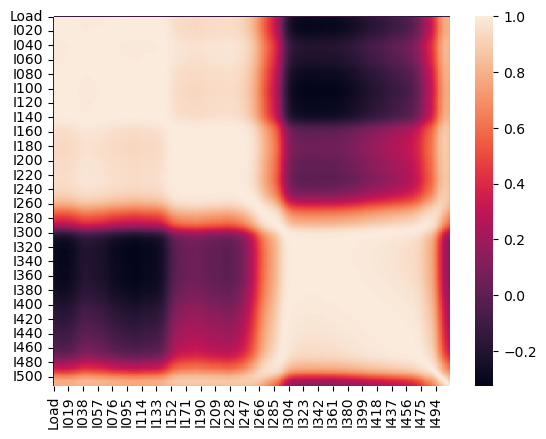

In [10]:
sns.heatmap(dmem_virus_df.corr(numeric_only=True))

## Relationship Between Viral Load and Spectrum Values

## Split Target Variable and Design Matrix

In [13]:
# Split predictor and response variables
y_dmem_reg = dmem_virus_df['Load']
X_dmem = dmem_virus_df.drop(['Load', 'SID','Type','Matrix'], axis=1)

y_pbs_reg = pbs_virus_df['Load']
X_pbs = pbs_virus_df.drop(['Load', 'SID','Type','Matrix'], axis=1)

## Target Variable Distribution

<Axes: xlabel='Load', ylabel='count'>

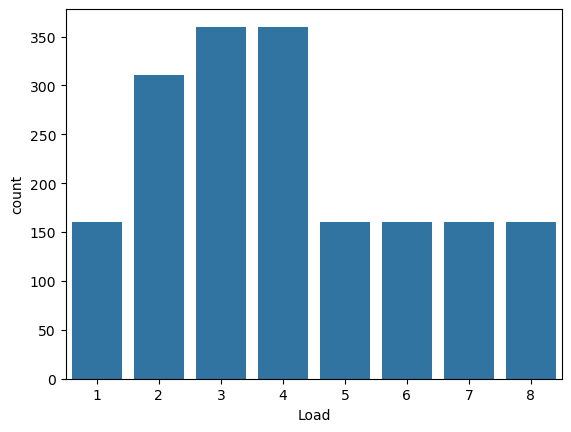

In [15]:
sns.countplot(data=dmem_virus_df, x=y_dmem_reg)

<Axes: xlabel='Load', ylabel='count'>

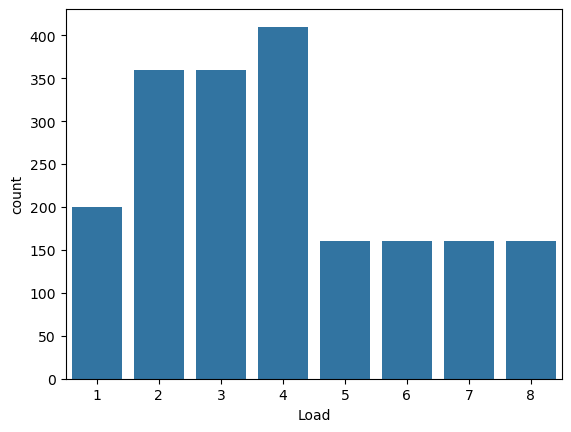

In [16]:
sns.countplot(data=pbs_virus_df, x=y_pbs_reg)

### Standardize 

In [18]:
# Use standard scaler to standardize features, to prepare for feature engineering.
scaler = StandardScaler()
X_dmem_std = scaler.fit_transform(X_dmem)
X_pbs_std = scaler.fit_transform(X_pbs)

### Remove Outliers

In [20]:
# Use isolation forest to remove outliers.
def remove_outliers_iso_forest(X, y):
    clf = IsolationForest(random_state=42)
    outlier_pred = clf.fit_predict(X)
    # Remove Outliers identified
    X_clean_standardized = X[outlier_pred == 1]  
    y_clean = y[outlier_pred == 1]
    
    return X_clean_standardized, y_clean, outlier_pred

X_dmem_std_clean, y_dmem_clean, outlier_pred_dmem = remove_outliers_iso_forest(X_dmem_std, y_dmem_reg)
X_pbs_std_clean, y_pbs_clean, outlier_pred_pbs = remove_outliers_iso_forest(X_pbs_std, y_pbs_reg)

In [21]:
# dmem
lr = LinearRegression()
lr_pca_dmem_results = cross_validate(lr, X_dmem_std_clean, y_dmem_clean, cv=5, scoring='neg_mean_squared_error' )
print(lr_pca_dmem_results['test_score'])
print(f'MSE: {-np.mean(lr_pca_dmem_results['test_score'])}')

[ -5.68345039 -21.24953708 -11.62740461  -8.26433047 -29.45846601]
MSE: 15.256637712153715


In [22]:
# pbs
lr = LinearRegression()
lr_pca_dmem_results = cross_validate(lr, X_pbs_std_clean, y_pbs_clean, cv=5, scoring='neg_mean_squared_error' )
print(lr_pca_dmem_results['test_score'])
print(f'MSE: {-np.mean(lr_pca_dmem_results['test_score'])}')

[-0.42339531 -4.1606891  -5.22696662 -2.0043497  -4.4459166 ]
MSE: 3.2522634679033873


## Dimension Reduction 

### PCA

In [25]:
def pca_scree(X, range):
    pca = PCA(n_components=range)
    scores = pca.fit_transform(X)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ticks = np.arange(pca.n_components_)+1
    ax = axes[0]
    ax.plot(ticks,
            pca.explained_variance_ratio_,
            marker='o')
    ax.set_xlabel('Principal Component');
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_ylim([0,1])
    ax.set_xticks(ticks)
    
    ax = axes[1]
    ax.plot(ticks,
            pca.explained_variance_ratio_.cumsum(),
            marker='o')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Cumulative Proportion of Variance Explained')
    ax.set_ylim([0, 1])
    ax.set_xticks(ticks)
    fig

In [26]:
# Scree plots for PCA in order to determine number of componentes, no titles as report in in Latex and easier to add titles then.

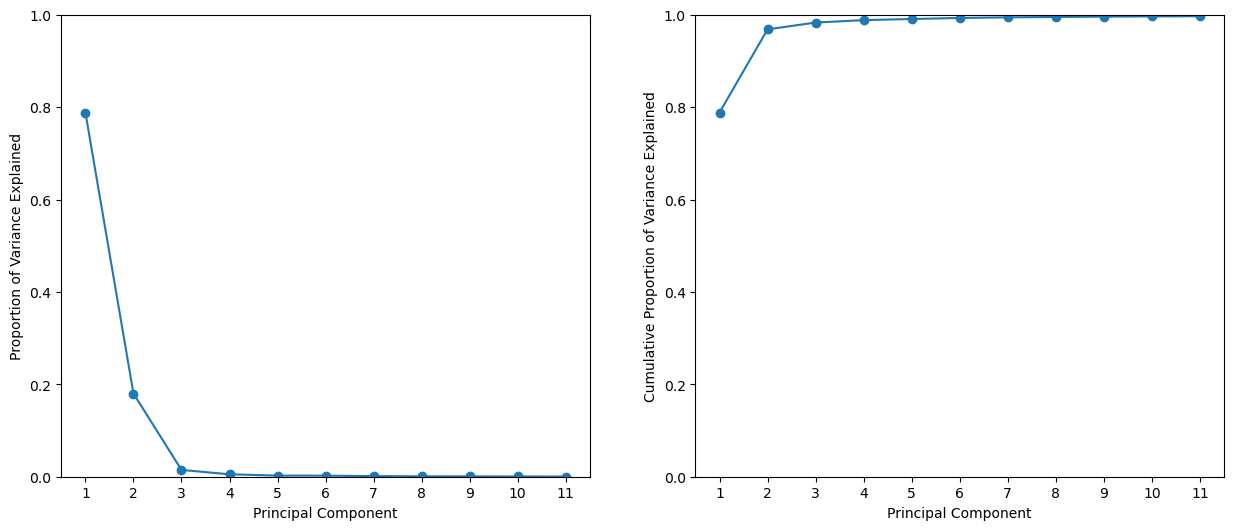

In [27]:
pca_scree(X_dmem_std_clean, 11)

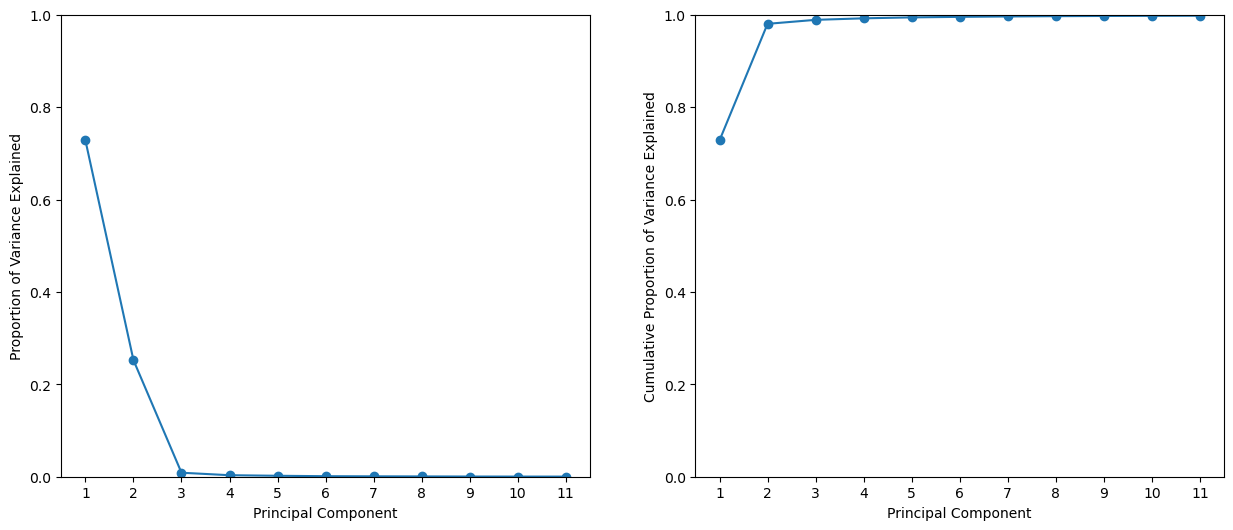

In [28]:
pca_scree(X_pbs_std_clean, 11)

In [29]:
# Set PCA to 3 components
pca = PCA(n_components=3)
X_pca_dmem = pca.fit_transform(X_dmem_std_clean)
X_pca_pbs = pca.fit_transform(X_pbs_std_clean) 

# Conovert back to df
X_pca_dmem_df = pd.DataFrame(X_pca_dmem, columns=['PC1', 'PC2', 'PC3'])
X_pca_pbs_df = pd.DataFrame(X_pca_pbs, columns=['PC1', 'PC2', 'PC3'])

<Axes: >

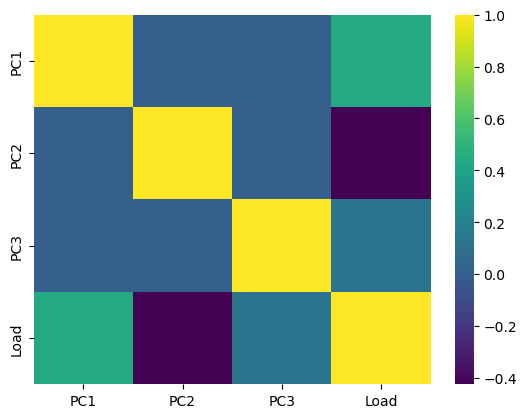

In [30]:
X_pca_dmem_and_y = X_pca_dmem_df.copy()
X_pca_dmem_and_y['Load'] = y_dmem_clean
sns.heatmap(X_pca_dmem_and_y.corr(numeric_only=True), cmap="viridis")

<Axes: >

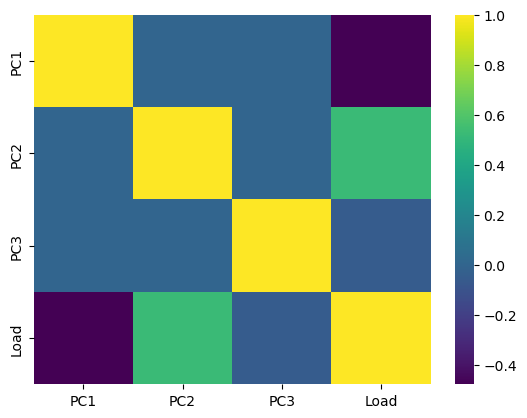

In [31]:
X_pca_pbs_and_y = X_pca_pbs_df.copy()
X_pca_pbs_and_y['Load'] = y_pbs_clean
sns.heatmap(X_pca_pbs_and_y.corr(numeric_only=True),cmap="viridis")

In [32]:
# Function to visualise the response variable in relation to 3 principle components
def pca_visual_three_dim(X_pca_df, y):
    
    target_and_PC = X_pca_df.copy()
    target_and_PC['Load'] = y
    
    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        target_and_PC['PC1'], 
        target_and_PC['PC2'], 
        target_and_PC['PC3'], 
        c=target_and_PC['Load'], 
        cmap='coolwarm', 
        edgecolor='k'
    )
    
    # Add color bar for 'Load' values
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Load')
    
    # Label axes and set title
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title("3D Scatter Plot of PC1, PC2, PC3 with Load as Color")
    
    plt.show()

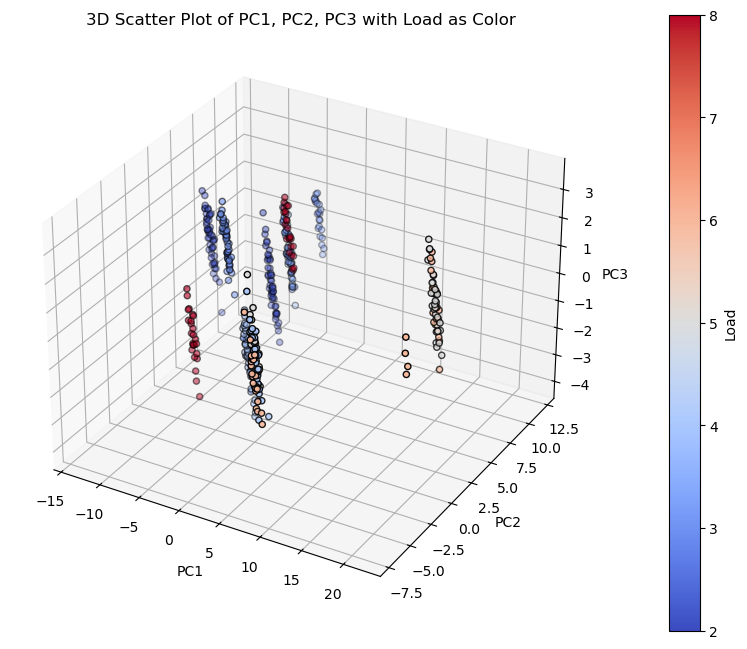

In [33]:
pca_visual_three_dim(X_pca_dmem_df, y_dmem_clean)

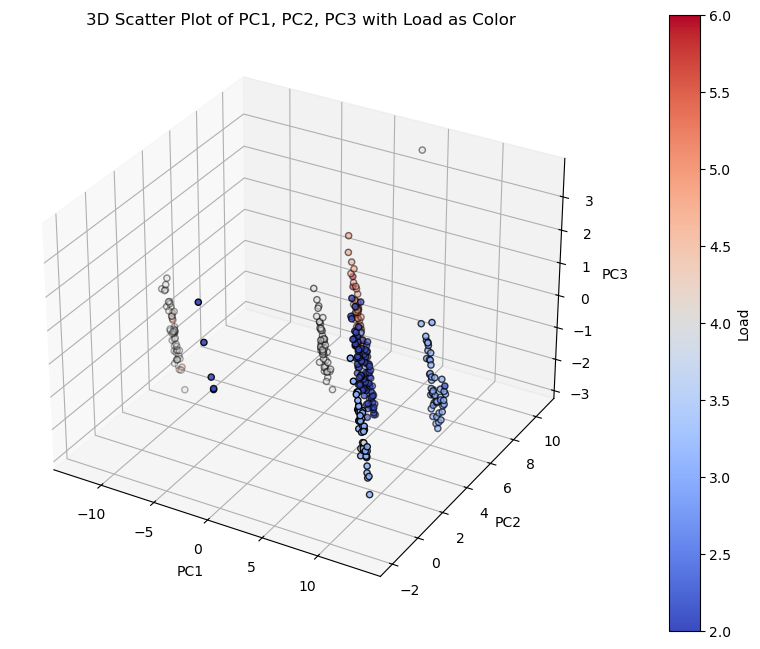

In [34]:
pca_visual_three_dim(X_pca_pbs_df, y_pbs_clean)

In [35]:
lr = LinearRegression()
lr_pca_dmem_results = cross_validate(lr, X_pca_dmem_df, y_dmem_clean, cv=5, scoring='r2' )
print(f'R^2 Linear Regressino with PCA dmem matrix: {np.mean(lr_pca_dmem_results['test_score'])}')

lr = LinearRegression()
lr_pca_pbs_results = cross_validate(lr, X_pca_pbs_df, y_pbs_clean, cv=5, scoring='r2' )
print(f'R^2 Linear Regressino with PCA pbs matrix: {np.mean(lr_pca_pbs_results['test_score'])}')

R^2 Linear Regressino with PCA dmem matrix: -1.4632589976088817
R^2 Linear Regressino with PCA pbs matrix: -0.6988089259809402


### PLS

In [37]:
def fit_PLS(X, y, max_components):
    # Specify number of components to test
    component_range = range(1, max_components + 1)
    mean_cv_scores = []  
    
    for n_components in component_range:
        pls = PLSRegression(n_components=n_components)
        cv_scores = cross_val_score(pls, X, y, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()  
        mean_cv_scores.append(mean_cv_score)
        print(f"Components: {n_components}, MSE: {mean_cv_score}")

    optimal_components = component_range[np.argmin(mean_cv_scores)]
    print(f"Optimal number of components: {optimal_components}")
    print(f"Min cross-validated MSE: {min(mean_cv_scores)}")

    optimal_pls = PLSRegression(n_components=optimal_components)
    X_optimal = optimal_pls.fit_transform(X, y)[0]  # Transform X with the fitted model

    return X_optimal, optimal_pls  #
    
    

y_dmem_std_clean = scaler.fit_transform(y_dmem_clean.to_frame())
y_pbs_std_clean = scaler.fit_transform(y_pbs_clean.to_frame())

In [38]:
X_dmem_PLS, dmem_PLS_model = fit_PLS(X_dmem_std_clean, y_dmem_clean, 10)
X_pbs_PLS, pbs_PLS_model = fit_PLS(X_pbs_std_clean, y_pbs_clean, 10)

Components: 1, MSE: 5.585234021338496
Components: 2, MSE: 6.400505980231688
Components: 3, MSE: 7.936968521568248
Components: 4, MSE: 7.742972475209145
Components: 5, MSE: 10.310992638045471
Components: 6, MSE: 11.30405754566489
Components: 7, MSE: 13.565319622451819
Components: 8, MSE: 15.763609244117202
Components: 9, MSE: 16.731011553175463
Components: 10, MSE: 17.93917678449356
Optimal number of components: 1
Min cross-validated MSE: 5.585234021338496
Components: 1, MSE: 4.720420988805129
Components: 2, MSE: 4.558832799788003
Components: 3, MSE: 5.102205223260555
Components: 4, MSE: 4.120128816231711
Components: 5, MSE: 3.4793094796304147
Components: 6, MSE: 3.548608194780269
Components: 7, MSE: 3.50201891474304
Components: 8, MSE: 3.790950379049419
Components: 9, MSE: 3.6550763730779936
Components: 10, MSE: 3.712086426491845
Optimal number of components: 5
Min cross-validated MSE: 3.4793094796304147


## Shrinkage Methods

### Lasso

In [41]:
# Use Lasso instead 
def lasso(X, y):
    lasso = Lasso()
    parameters={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 100.0, 1000.0]}
    lasso_regressor = GridSearchCV(lasso, parameters, scoring= 'r2')
    lasso_model = lasso_regressor.fit(X, y)
    best_lasso_model = lasso_model.best_estimator_
    print(f'Optimal Lasso: {best_lasso_model}')
    non_zero_predictors = np.sum(best_lasso_model.coef_ != 0)
    print(f'Number of predictors with non-zero coefficients: {non_zero_predictors}')
    cv_results = cross_validate(lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(-cv_results['test_score'])
    cv_err = np.mean(-cv_results['test_score'])
    print(f'MSE: {cv_err}')

In [42]:
 lasso(X_dmem_std_clean, y_dmem_clean)

C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.317e+02, tolerance: 5.121e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.444e+02, tolerance: 4.067e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.421e+02, toleranc

Optimal Lasso: Lasso(alpha=0.5)
Number of predictors with non-zero coefficients: 0


C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+02, tolerance: 4.022e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+02, tolerance: 4.011e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.516e+02, toleranc

[2.52698746 6.45669834 2.72010112 5.85363282 8.14306539]
MSE: 5.14009702717312


In [43]:
 lasso(X_pbs_std_clean, y_pbs_clean)

C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e+02, tolerance: 5.411e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.128e+02, tolerance: 4.436e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.412e+02, toleranc

Optimal Lasso: Lasso(alpha=0.01)
Number of predictors with non-zero coefficients: 43


C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+02, tolerance: 4.003e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.529e+02, tolerance: 4.578e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e+02, toleranc

[3.89338753 4.84619949 5.09259291 6.01991765 6.50263085]
MSE: 5.270945684775347


C:\Users\josep\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.346e+01, tolerance: 4.593e-01
  model = cd_fast.enet_coordinate_descent(


## Move Beyond Linearity

### Polynomials

In [46]:
def poly(X,y, degree):
    # Set up a range of polynomial degrees to test
    degrees = range(1, degree+1)
    for degree in degrees:
        print(degree)
        # Generate polynomial features
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)
        
        model = LinearRegression()
        
        # MSE scores
        cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
        
        print(f'Degree {degree} - Average MSE score: {-np.mean(cv_scores):.4f}')
        print(f'MSE scores for each fold: {cv_scores}')


In [47]:
poly(X_dmem_PLS, y_dmem_clean, 4)

1
Degree 1 - Average MSE score: 5.4365
MSE scores for each fold: [-2.46506252 -6.63437569 -2.69102294 -5.83143091 -9.5606357 ]
2
Degree 2 - Average MSE score: 8.6221
MSE scores for each fold: [-15.58615407  -7.56952513  -2.6863779   -5.74497505 -11.52368336]
3
Degree 3 - Average MSE score: 8.7966
MSE scores for each fold: [-16.4587921   -5.9004501   -4.07284249  -5.47107069 -12.08005819]
4
Degree 4 - Average MSE score: 10.5982
MSE scores for each fold: [-25.25000148  -6.10925935  -3.30998271  -7.08340097 -11.23816122]


In [48]:
 poly(X_pbs_PLS, y_pbs_clean, 4)

1
Degree 1 - Average MSE score: 2.0956
MSE scores for each fold: [-1.86162137 -1.04762599 -2.70114529 -1.36517157 -3.5025741 ]
2
Degree 2 - Average MSE score: 4.6704
MSE scores for each fold: [-5.02233335 -3.70271371 -3.86510387 -2.4209123  -8.34115013]
3
Degree 3 - Average MSE score: 16.0773
MSE scores for each fold: [ -7.06469922 -28.33754319  -4.4724614  -25.47874534 -15.03294198]
4
Degree 4 - Average MSE score: 91.9468
MSE scores for each fold: [ -44.31171398 -347.26498784  -10.48364105  -45.42730585  -12.24648663]


### Neural Network

In [50]:
# Must set default paramaters for Grid Search to work
def create_model(optimizer='adam', input_dim=8, activation='relu', num_hidden_layers=1):
    # Initialise Neural Netork
    nn = Sequential() # tf.keras.Sequential, way to model NNs as a chain of tensors, input -> ... -> output.
    # Input
    nn.add(Input(shape=(input_dim,)))
    # Hidden layers
    for i in range(num_hidden_layers):
        nn.add(Dense(64, activation=activation))
    # Output layer, load estimate.
    nn.add(Dense(1))  

    # .compile just sets configuration
    nn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()]) 
    
    return nn

# Function to perform regression given design matrix and target variable
def NN_regression(X, y):
    # Use KerasRegressor wrapper in order to use sklearn tools with Keras. 
    model = KerasRegressor(model=create_model, input_dim=X.shape[1], num_hidden_layers=1, epochs=1, verbose=0)
    
    param_grid = {
        'epochs':  [1, 2, 5, 10, 20],
        'num_hidden_layers' : [1,2]
    }
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_result = grid.fit(X, y)
    
    return grid_result.best_params_, -grid_result.best_score_

In [51]:
#dmem_nn_params_pls, dmem_nn_MSE_pls = NN_regression(X_dmem_PLS, y_dmem_clean)
#pbs_nn_params_pls, pbs_nn_MSE_pls = NN_regression(X_pbs_PLS, y_pbs_clean)

In [52]:
#print('PLS')
#print(f'dmem | optimal parameters: {dmem_nn_params_pls} MSE: {dmem_nn_MSE_pls}')
#print(f'pbs | optimal parameters: {pbs_nn_params_pls} MSE: {pbs_nn_MSE_pls}')

# 2. Classification

## Preprocessing

In [55]:
# new target variable target variable
y_clf_dmem = dmem_virus_df['Type']
y_clf_pbs = pbs_virus_df['Type']
# make y binary (X, Y) -> (1, 0), handle spaces
y_bin_dmem = y_clf_dmem.str.strip().map({'X': 1, 'Y': 0})
y_bin_pbs = y_clf_pbs.str.strip().map({'X': 1, 'Y': 0})

### Outlier Removal

In [57]:
def remove_outliers_iso_forest(X, y):
    clf = IsolationForest(random_state=42)
    outlier_pred = clf.fit_predict(X)
    # Remove Outliers identifie
    X_clean_standardized = X[outlier_pred == 1]  
    y_clean = y[outlier_pred == 1]
    
    return X_clean_standardized, y_clean, outlier_pred

# Already standardized with standard scaler
X_dmem_std_clean_clf, y_dmem_clean_clf, outlier_pred_dmem = remove_outliers_iso_forest(X_dmem_std, y_bin_dmem)
X_pbs_std_clean_clf, y_pbs_clean_clf, outlier_pred_pbs = remove_outliers_iso_forest(X_pbs_std, y_bin_pbs)

<Axes: xlabel='Type', ylabel='count'>

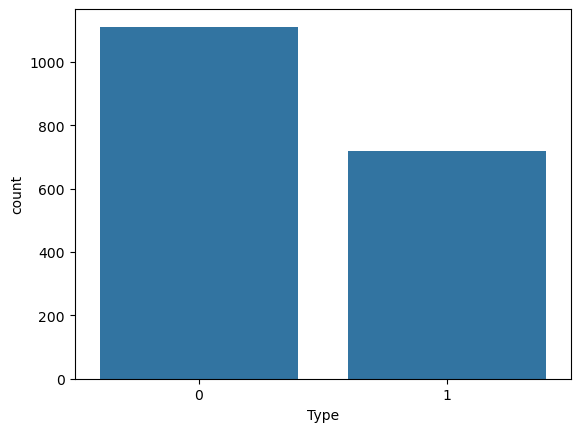

In [58]:
sns.countplot(x=y_bin_dmem)

<Axes: xlabel='Type', ylabel='count'>

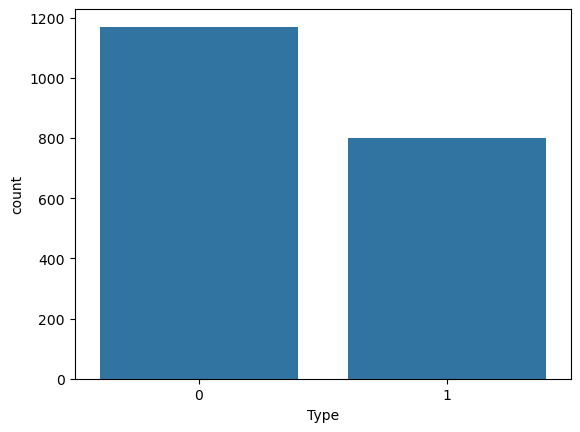

In [59]:
sns.countplot(x=y_bin_pbs)

### PCA

#### Scree Plot

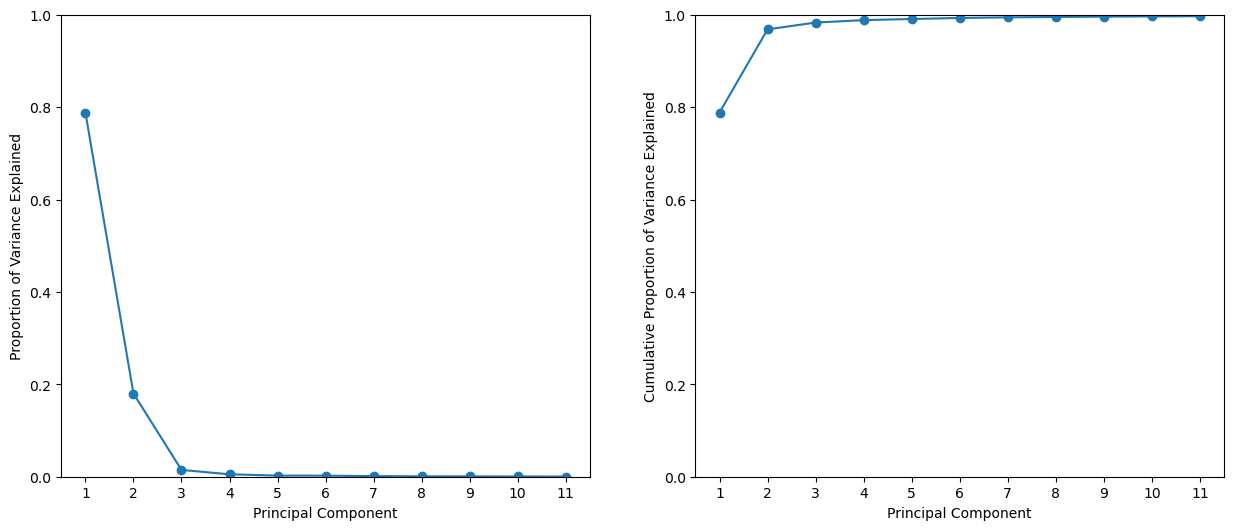

In [62]:
pca_scree(X_dmem_std_clean_clf, 11)

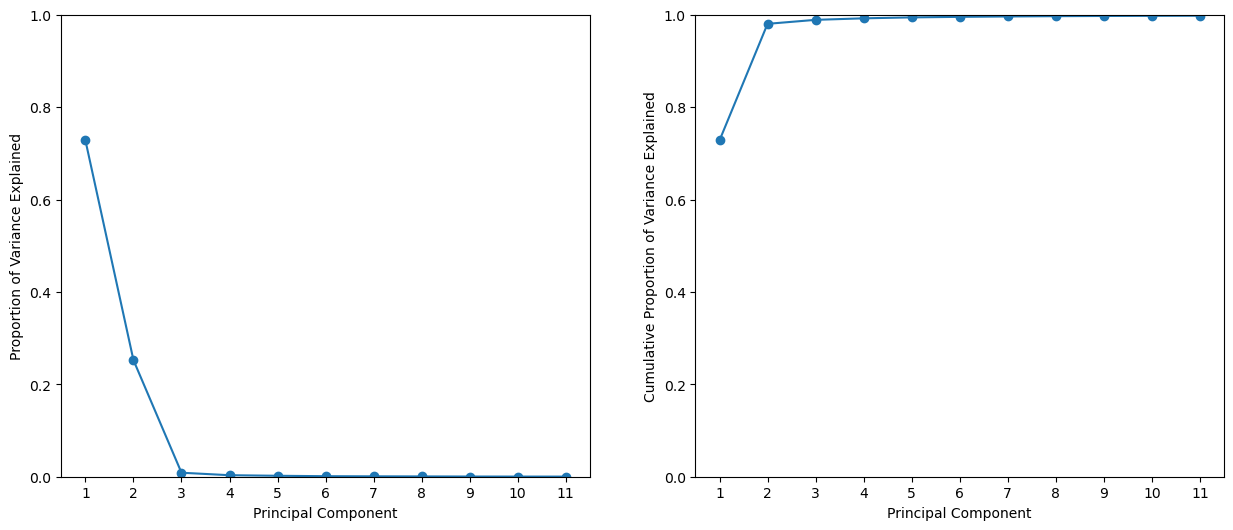

In [63]:
pca_scree(X_pbs_std_clean_clf, 11)

#### Correlation with Target

In [65]:
# Set PCA to 3 components
pca = PCA(n_components=3)
X_pca_dmem_clf = pca.fit_transform(X_dmem_std_clean_clf)
X_pca_pbs_clf = pca.fit_transform(X_pbs_std_clean_clf) 

In [66]:
# Conovert back to df
X_pca_dmem_clf_df = pd.DataFrame(X_pca_dmem_clf, columns=['PC1', 'PC2', 'PC3'])
X_pca_pbs_clf_df = pd.DataFrame(X_pca_pbs_clf, columns=['PC1', 'PC2', 'PC3'])

<Axes: >

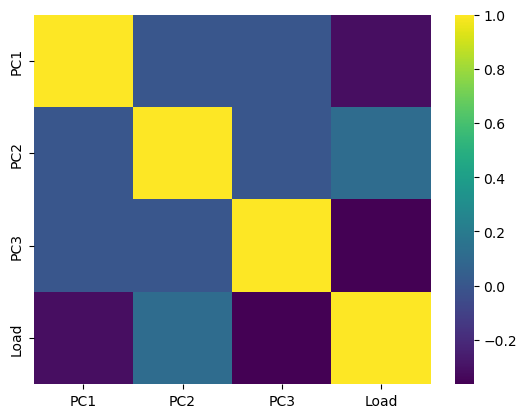

In [67]:
X_pca_dmem_and_y_clf = X_pca_dmem_clf_df.copy()
X_pca_dmem_and_y_clf['Load'] = y_dmem_clean_clf
sns.heatmap(X_pca_dmem_and_y_clf.corr(numeric_only=True), cmap="viridis")

<Axes: >

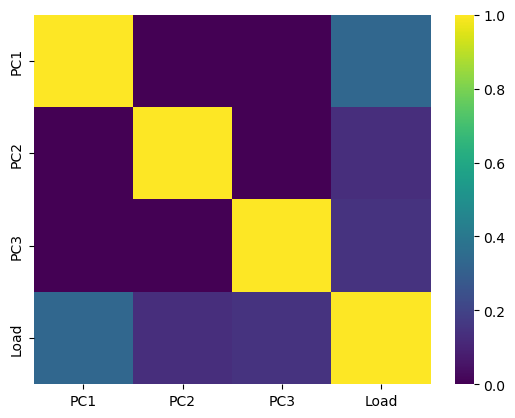

In [68]:
X_pca_pbs_and_y_clf = X_pca_pbs_clf_df.copy()
X_pca_pbs_and_y_clf['Load'] = y_pbs_clean_clf
sns.heatmap(X_pca_pbs_and_y_clf.corr(numeric_only=True), cmap="viridis")

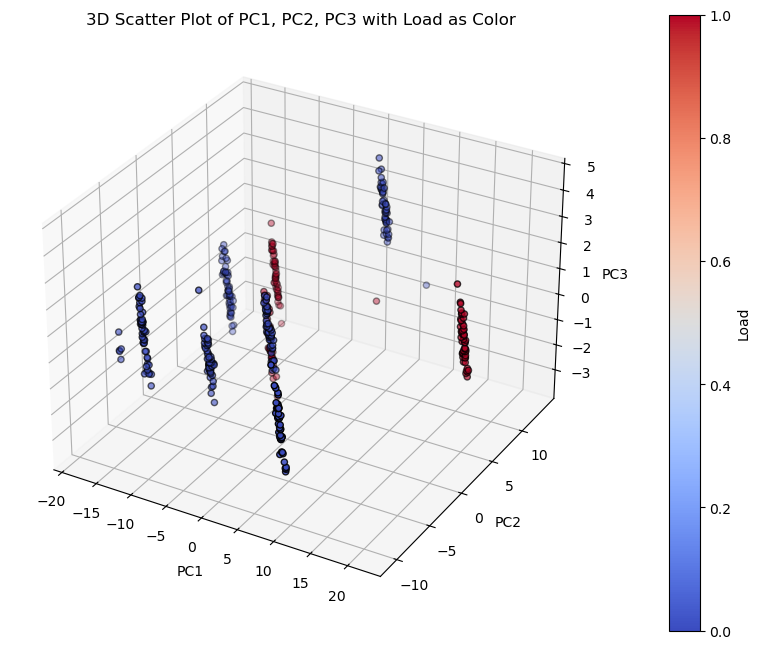

In [69]:
pca_visual_three_dim(X_pca_pbs_clf_df, y_dmem_clean_clf)

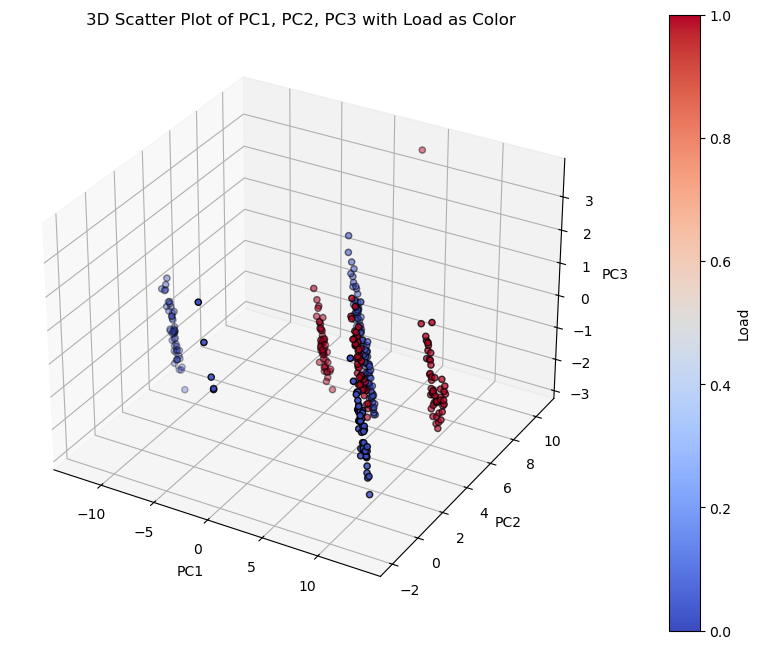

In [70]:
pca_visual_three_dim(X_pca_pbs_clf_df, y_pbs_clean_clf)

### PLS

In [72]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

def fit_PLS_for_classification(X, y, max_components):
    component_range = range(1, max_components + 1)
    # mean cv score relative to number of components.
    mean_cv_scores = []
    
    for n_components in component_range:
        # Fit PLS
        pls = PLSRegression(n_components=n_components)
        X_transformed = pls.fit_transform(X, y)[0]
        
        # - DA
        clf = LogisticRegression(max_iter=1000)
        cv_scores = cross_val_score(clf, X_transformed, y, cv=5, scoring='f1')
        mean_cv_score = np.mean(cv_scores)
        mean_cv_scores.append(mean_cv_score)
        
    # optimal number of components based on cross-validated score
    optimal_components = component_range[np.argmax(mean_cv_scores)]
    best_acc = np.max(mean_cv_scores)
    # transformation using the optimal number of components
    optimal_pls = PLSRegression(n_components=optimal_components)
    X_optimal = optimal_pls.fit_transform(X, y)[0]
    
    return X_optimal, optimal_pls,  optimal_components, best_acc

In [73]:
X_pbs_PLS_clf, pbs_PLS_model_clf, num_pbs, score_pbs = fit_PLS_for_classification(X_pbs_std_clean_clf, y_pbs_clean_clf, 20)
print(f'PBS| Components: {num_pbs}, accuracy: {score_pbs}')

X_dmem_PLS_clf, dmem_PLS_model_clf, num_dmem, score_dmem = fit_PLS_for_classification(X_dmem_std_clean_clf, y_dmem_clean_clf, 20)
print(f'DMEM| Components: {num_dmem}, accuracy: {score_dmem}')

PBS| Components: 18, accuracy: 0.9847622450802724
DMEM| Components: 13, accuracy: 0.9925355847388095


### Normality of Features

In [75]:
def graph_data_hist(data):
    # Plot histograms for numerical features
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    
    
    data.hist(bins=50, figsize=(12, 8))
    plt.show()

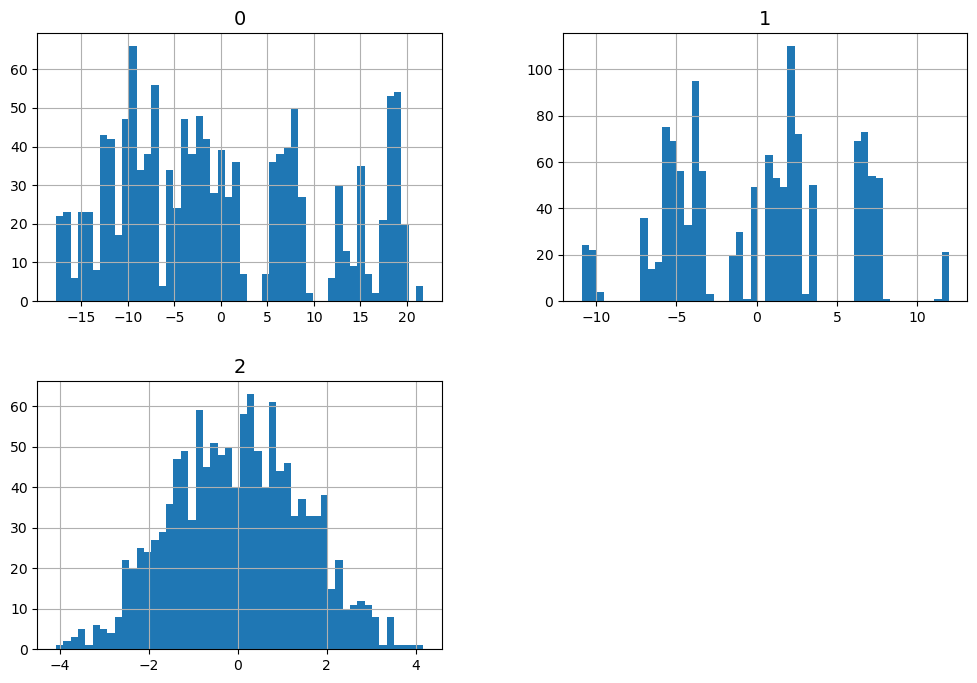

In [76]:
graph_data_hist(pd.DataFrame(X_pca_dmem))

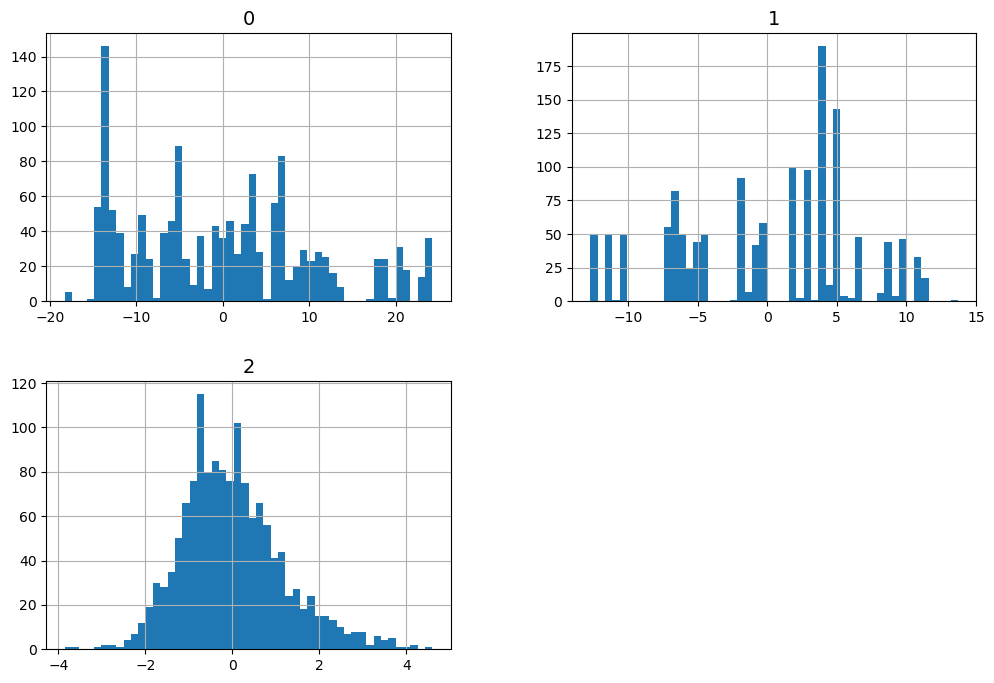

In [77]:
graph_data_hist(pd.DataFrame(X_pca_pbs))

### Ratio of Features to Observations

In [79]:
# Function for visualising confusion matrix for evaluating  classification models.
def CM_visualise(X, y, model):
    # Confusion Matrix
    # Generate cross-validated predictions
    y_pred_log = cross_val_predict(model, X, y, cv=10)
    # Create and plot the confusion matrix
    conf_matrix = confusion_matrix(y, y_pred_log)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model}")
    plt.show()

## Naive Bayes


In [81]:
gnb = GaussianNB()

In [82]:
cv = np.mean(cross_val_score(gnb, X_pca_pbs, y_pbs_clean_clf, cv=5, scoring='accuracy'))
print(cv)

0.5981726862017618


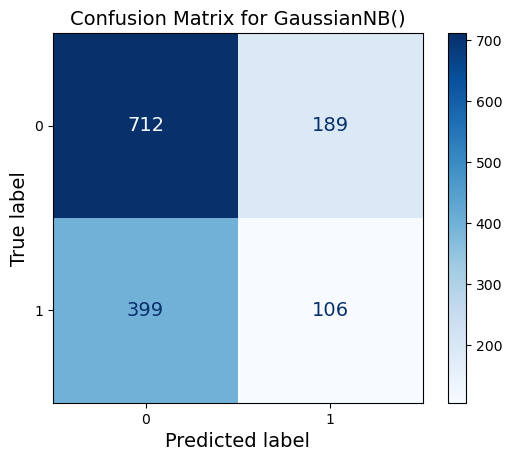

In [83]:
CM_visualise(X_pca_pbs, y_pbs_clean_clf, gnb)

In [84]:
cv = cross_val_score(gnb, X_pca_dmem, y_dmem_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.6348008578431372


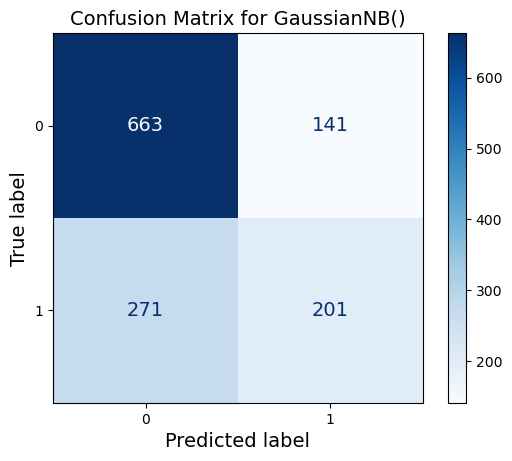

In [85]:
CM_visualise(X_pca_dmem, y_dmem_clean_clf, gnb)

## Logistic Regression

In [87]:
log_model = LogisticRegression(max_iter=1000)

In [88]:
cv = cross_val_score(log_model, X_pca_pbs, y_pbs_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.5483884808561117


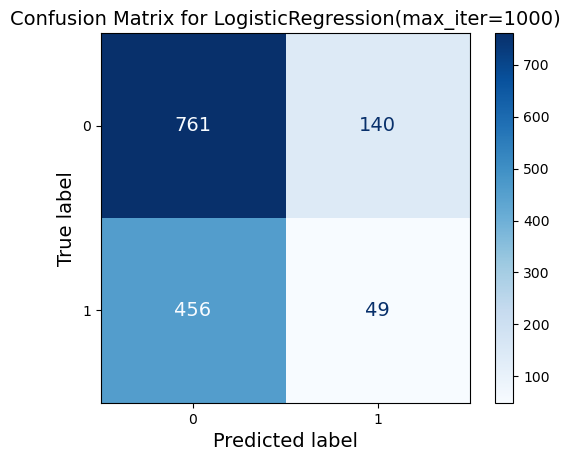

In [89]:
CM_visualise(X_pca_pbs, y_pbs_clean_clf, log_model)

In [90]:
cv = cross_val_score(log_model, X_pca_dmem, y_dmem_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.6332322303921568


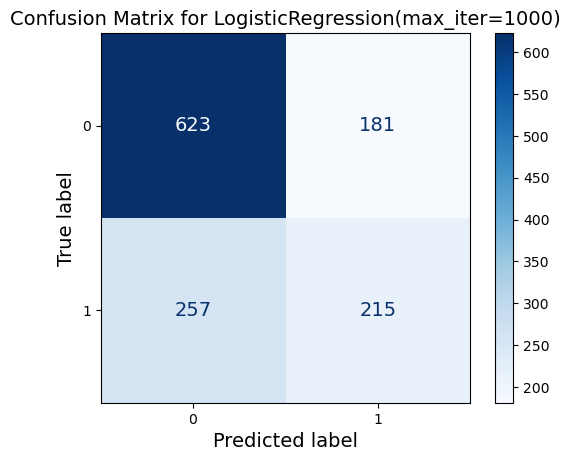

In [91]:
CM_visualise(X_pca_dmem, y_dmem_clean_clf, log_model)

## KNN Classifier

In [93]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [94]:
cv = cross_val_score(knn_clf, X_pca_pbs, y_pbs_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.6090457080840969


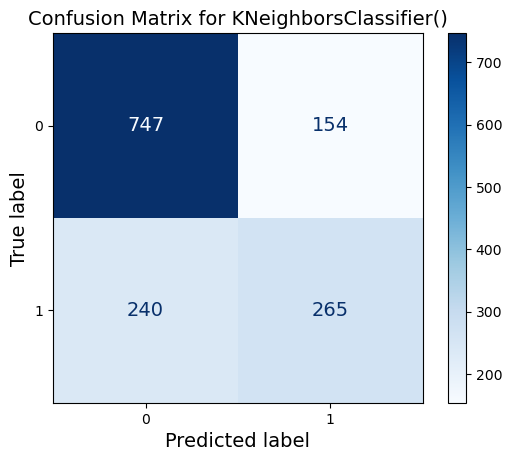

In [95]:
CM_visualise(X_pca_pbs, y_pbs_clean_clf, knn_clf)

In [96]:
cv = cross_val_score(knn_clf, X_pca_dmem, y_dmem_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.7446200980392157


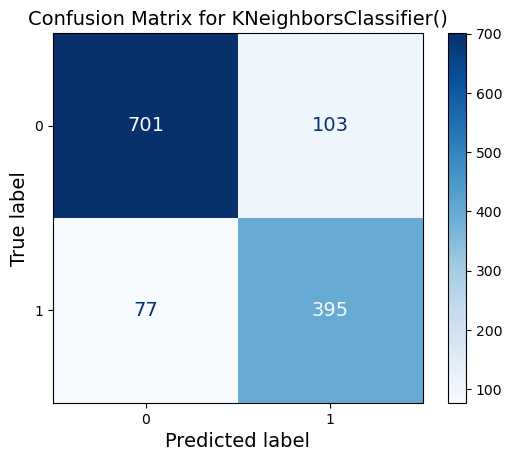

In [97]:
CM_visualise(X_pca_dmem, y_dmem_clean_clf, knn_clf)

## LDA

In [99]:
lda = LDA()

In [100]:
cv = cross_val_score(lda, X_pca_pbs, y_pbs_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.5540698114636178


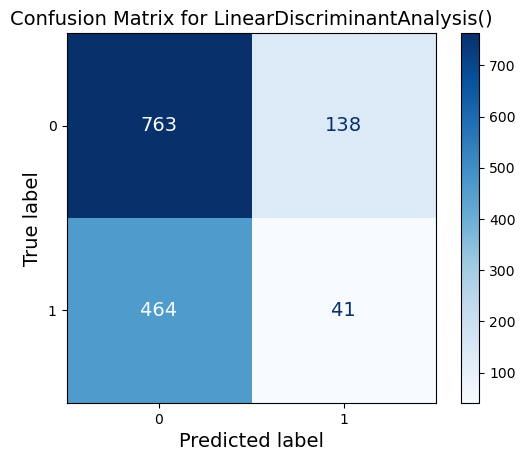

In [101]:
CM_visualise(X_pca_pbs, y_pbs_clean_clf, lda)

In [102]:
cv = cross_val_score(lda, X_pca_dmem, y_dmem_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.6277420343137254


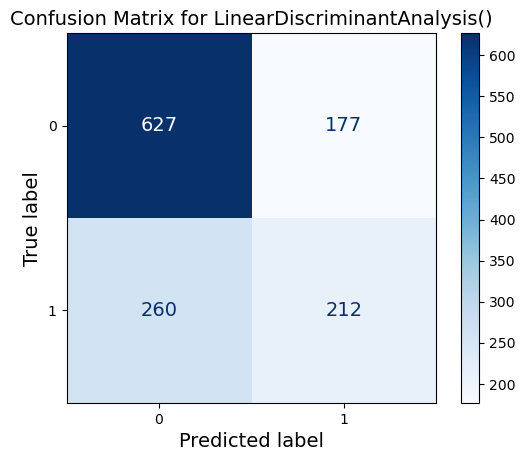

In [103]:
CM_visualise(X_pca_dmem, y_dmem_clean_clf, lda)

## QDA

In [105]:
qda = QDA()

In [106]:
cv = cross_val_score(qda, X_pca_pbs, y_pbs_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.5683349738774892


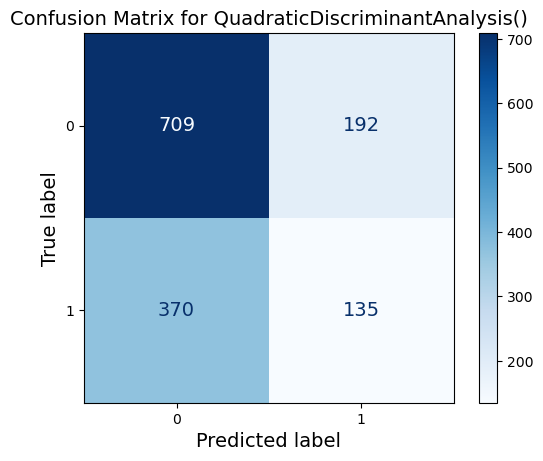

In [107]:
CM_visualise(X_pca_pbs, y_pbs_clean_clf, qda)

In [108]:
cv = cross_val_score(qda, X_pca_dmem, y_dmem_clean_clf, cv=5, scoring='accuracy')
print(np.mean(cv))

0.6183302696078432


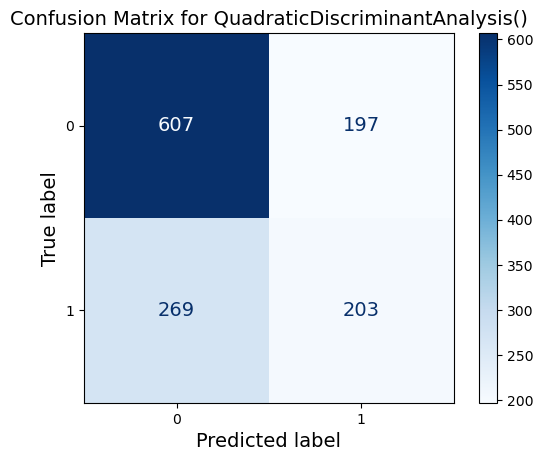

In [109]:
CM_visualise(X_pca_dmem, y_dmem_clean_clf, qda)

# 3. Clustering

## Preprocessing

In [112]:
# Use full data set
cluster_data = virus_df

### Split X and y

In [114]:
# Sprectrum data as design matrix
X_cluster = cluster_data[cluster_data.columns[4:517]]
# For evaluating clustering based on load level
y_cluster_load = cluster_data['Load']

### Standardization

In [116]:
# Standardize, so as to compare performance with and without.
scaler  = StandardScaler()
X_cluster_std = scaler.fit_transform(X_cluster)

### Outlier Removal (Unsupervised)

In [118]:
# Unsupervised outlier removal.
def outlier_removal_lof(X, y):
    LOF = LocalOutlierFactor(n_neighbors=2)
    outlier_pred = LOF.fit_predict(X)
    
    X_clean = X[outlier_pred == 1] 
    y_clean = y[outlier_pred == 1] 
    
    return X_clean, y_clean

In [119]:
X_cluster_std_clean, y_cluster_std_clean = outlier_removal_lof(X_cluster_std, y_cluster_load)
X_cluster_clean, y_cluster_clean = outlier_removal_lof(X_cluster, y_cluster_load)

### PCA

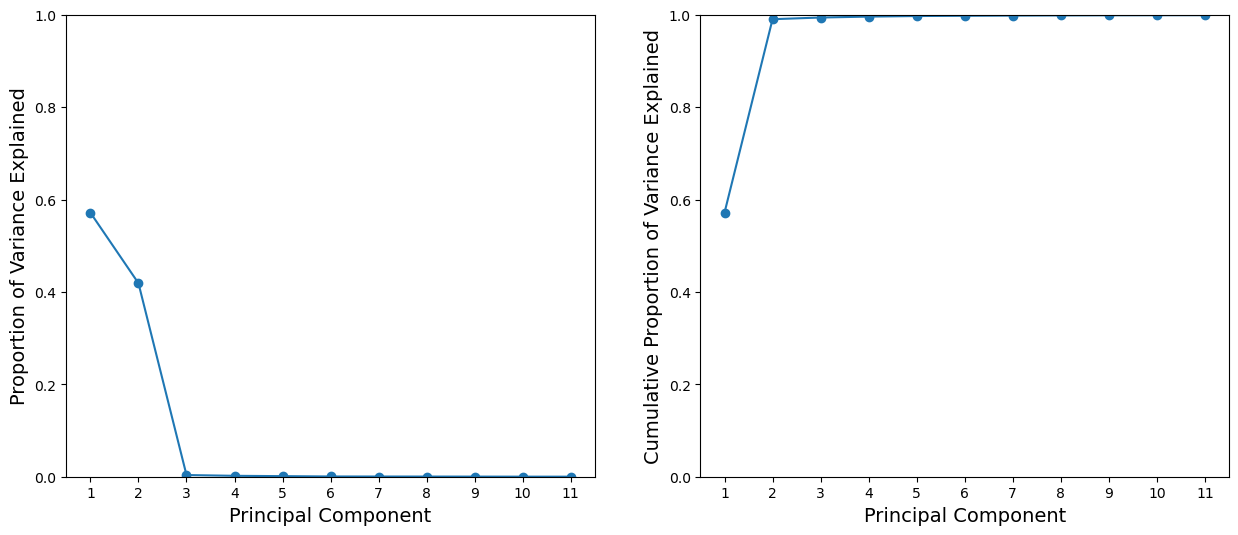

In [121]:
# Use PCA as it is an unsupervised dimension reduction (colinearity removal) method.
pca_scree(X_cluster_std_clean, 11)

In [122]:
pca = PCA(n_components=3)
X_cluster_pca = pca.fit_transform(X_cluster_std_clean)

## Kmeans  

In [124]:
# Define range for k values (number of centroids)
def plot_kmeans(X, y, max_k=10):
    K = range(2, max_k)

    fits = []
    inertia = []
    silhouette_scores = []
    accuracies = []
    # Iterate over different k values
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(X)
        fits.append(kmeans)

        # inertia (wcss), distance of x_i to centroid => how tightly packed (defined) clusters are. 
        inertia.append(kmeans.inertia_)
        # silhouette score => is point in the right cluster -1 -> 1
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
        
        labels = kmeans.labels_
        label_mapping = np.zeros_like(labels)
    
        for i in range(k):
            mask = (labels == i)
            # use mode() to find most frequent label.
            label_mapping[mask] = mode(y[mask])[0]
    
        accuracy = accuracy_score(y, label_mapping)
        accuracies.append(accuracy)
    
        if X.shape[1] < 4:
            # Scatter plot for the clusters based on PC1 and PC2
            plt.figure(figsize=(6, 6))
            plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.title(f"K-Means Clustering Results with K={k}")
            plt.show()

    return inertia, silhouette_scores, accuracies

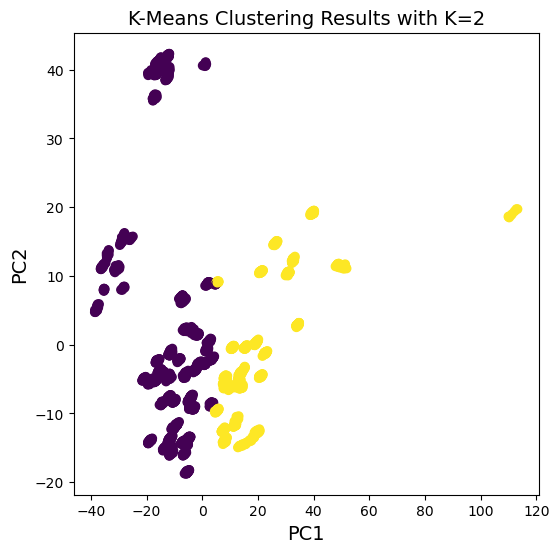

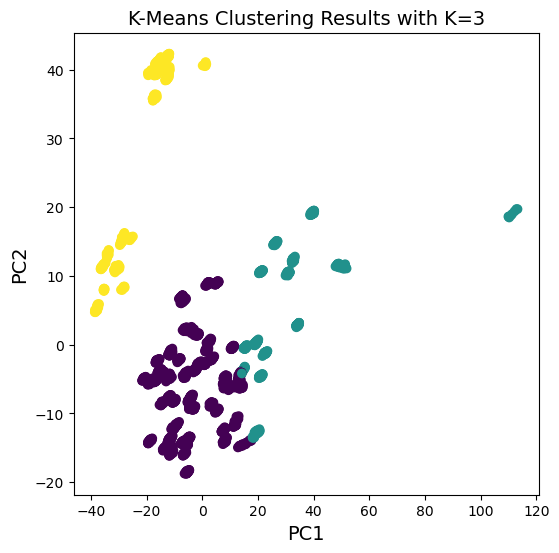

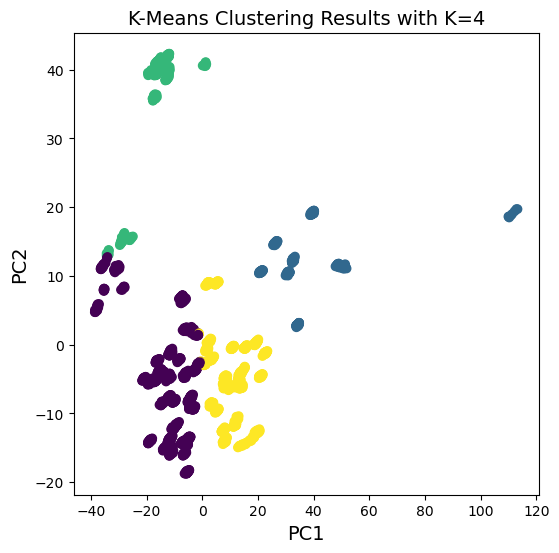

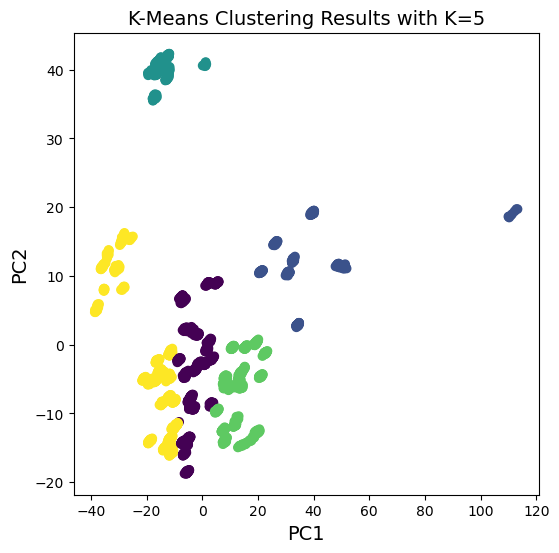

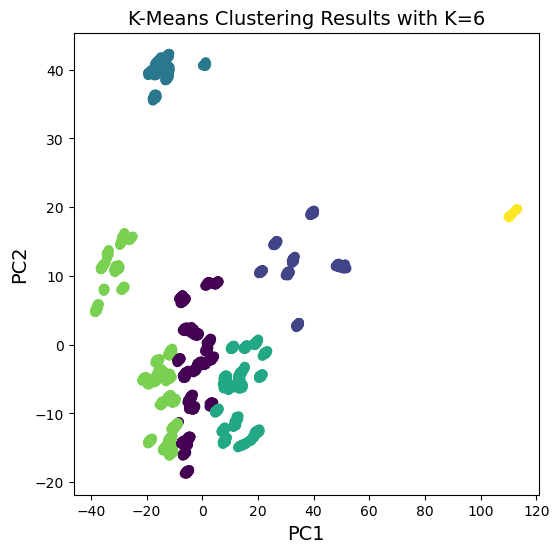

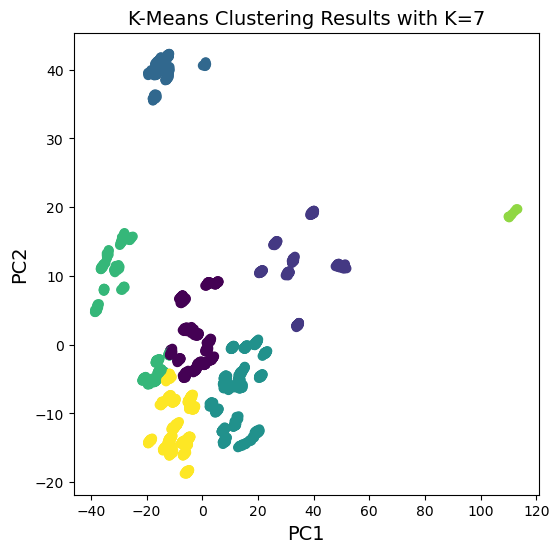

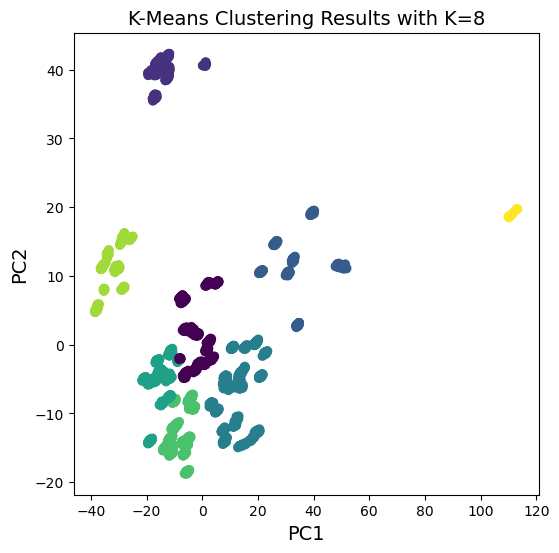

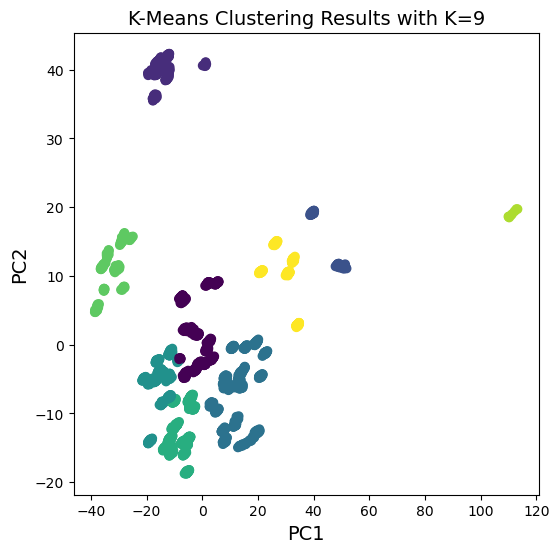

In [125]:
iniertia_load, silhouette_load, accuracies_load = plot_kmeans(X_cluster_pca, y_cluster_std_clean, 10)

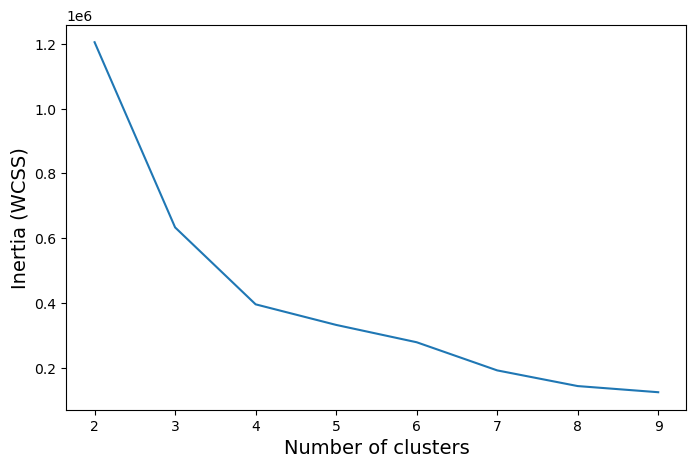

In [126]:
# Plot Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(iniertia_load)+2), iniertia_load)
#plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.show()

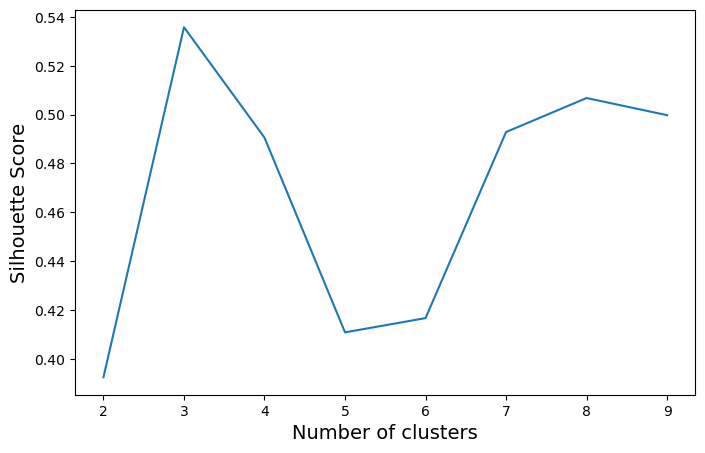

In [127]:
# Plot Silhouette Analysis graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(iniertia_load)+2), silhouette_load)
#plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

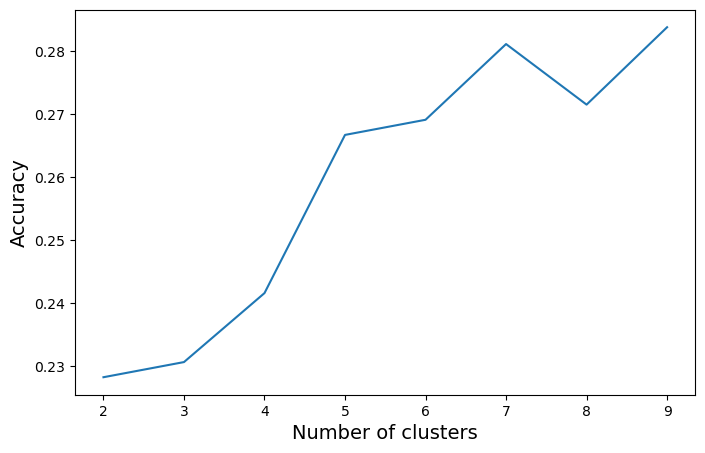

In [128]:
# Accuracy by K graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(accuracies_load)+2), accuracies_load)
#plt.title('Accuracy Score of Clusters Compared to True Classes')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

In [129]:
inertia_load_unstd, silhouette_load_unstd, accuracies_load_unstd = plot_kmeans(X_cluster_clean, y_cluster_clean, 10)

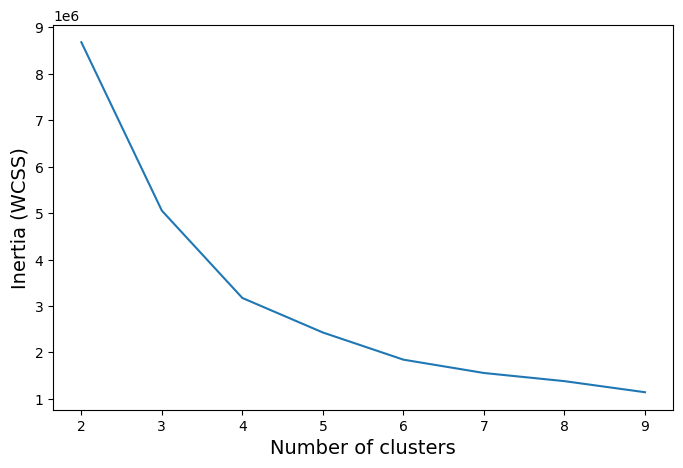

In [130]:
# Plot Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(inertia_load_unstd)+2), inertia_load_unstd)
#plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.show()

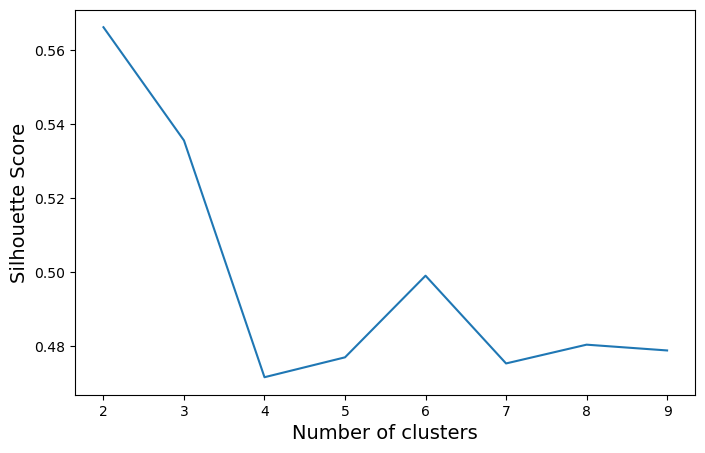

In [131]:
# Plot Silhouette Analysis graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(inertia_load_unstd)+2), silhouette_load_unstd)
#plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

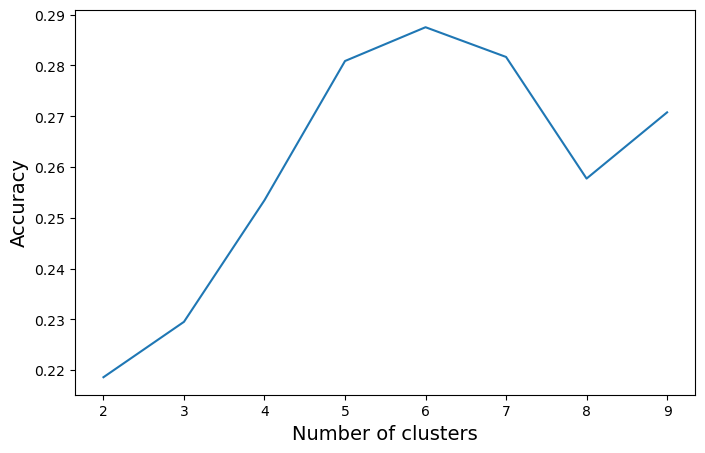

In [132]:
# Accuracy by K graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(accuracies_load_unstd)+2), accuracies_load_unstd)
#plt.title('Accuracy Score of Clusters Compared to True Classes')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

## Hierarchichal

In [134]:
# Complete Linkage
hc_complete = HClust(distance_threshold=0, 
                n_clusters = None,
                linkage = 'complete')
# Average Linkage
hc_ave = HClust(distance_threshold=0, 
                n_clusters = None,
               linkage = 'average')
# Single linkage
hc_sing = HClust(distance_threshold=0, 
                n_clusters = None,
               linkage = 'single')

# Centroid linkage
hc_ward = HClust(distance_threshold=0, 
                n_clusters = None,
               linkage = 'ward')

### PCA

In [136]:
# No preconceived chopping
cargs= {'color_threshold': -np.inf,
       'above_threshold_color': 'black'
       }

In [137]:
def plot_by_linkage(X):
    # By linkage Type complete, average, single, centroid
    fig, ax = plt.subplots(2, 2, figsize=(16, 8)) 
    
    # complete
    hc_complete.fit(X)
    linkage_complete = compute_linkage(hc_complete)
    dendrogram(linkage_complete, ax=ax[0,0], **cargs)
    ax[0,0].set_title("Complete Linkage")
    ax[0,0].set_xticks([])
    # average
    hc_ave.fit(X)
    linkage_ave = compute_linkage(hc_ave)
    dendrogram(linkage_ave, ax=ax[0,1], **cargs)
    ax[0,1].set_title("Average Linkage")
    ax[0,1].set_xticks([])
    
    # single
    hc_sing.fit(X)
    linkage_sing = compute_linkage(hc_sing)
    dendrogram(linkage_sing, ax=ax[1,0], **cargs)
    ax[1,0].set_title('Single Linkage')
    ax[1,0].set_xticks([])
    
    # centroid
    hc_ward.fit(X)
    linkage_ward = compute_linkage(hc_ward)
    dendrogram(linkage_ward, ax=ax[1,1], **cargs)
    ax[1,1].set_title('Ward Linkage')
    ax[1,1].set_xticks([])
    
    plt.show()

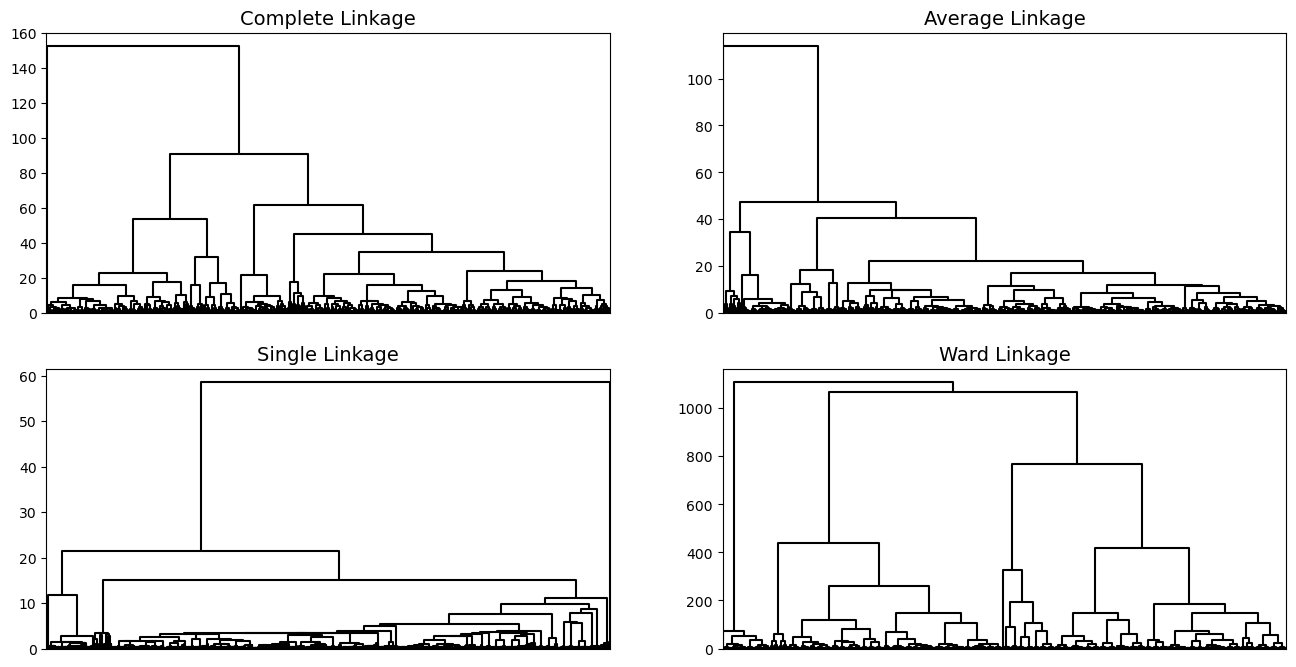

In [138]:
plot_by_linkage(X_cluster_pca)

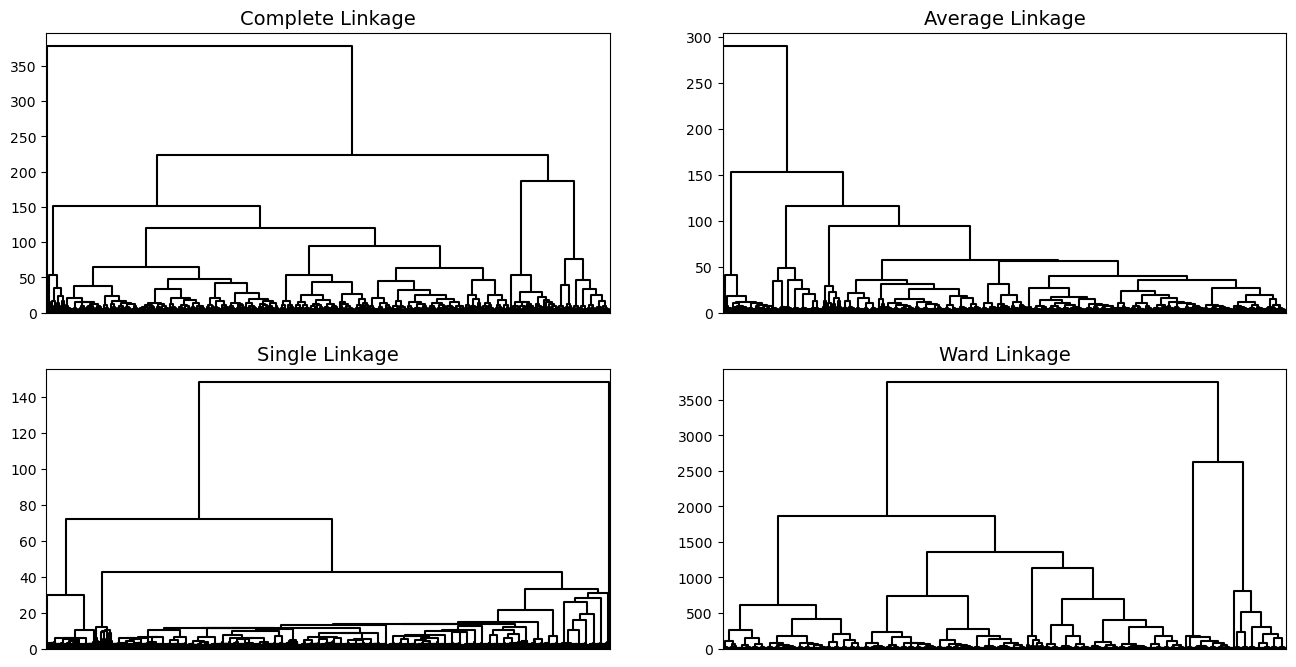

In [139]:
plot_by_linkage(X_cluster_clean)

## DBSCAN

In [141]:
dbscan = DBSCAN(eps=3, min_samples=2).fit(X_cluster_pca)
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise = list(dbscan.labels_).count(-1)

print('pca')
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

pca
Number of clusters: 30
Number of noise points: 0


In [247]:
dbscan = DBSCAN(eps=3, min_samples=2).fit(X_cluster_clean)
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise = list(dbscan.labels_).count(-1)

print('unstd')
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

unstd
Number of clusters: 124
Number of noise points: 176
